In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alaahamedabdo
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 1.61GB/s]

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight   # NEW: for class weights

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications.efficientnet import preprocess_input   # NEW: preprocessing for EfficientNet

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('modules loaded')


modules loaded


Data Preprocessing
Read data and store it in dataframe


Split dataframe into train, valid, and test




In [ ]:
# -------- Train dataframe --------
train_data_dir = r'/content/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = sorted(os.listdir(train_data_dir))   # fixed stored
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

display(train_df.head())

#------------------------------------------------------------------------------------------
# -------- Test dataframe (before split to valid/test) --------

test_data_dir = '/content/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = sorted(os.listdir(test_data_dir))
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis=1)

#----------------------------------------------------------------------------------------
# -------- Split valid / test --------

valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=123)

print("Train size:", len(train_df))
print("Valid size:", len(valid_df))
print("Test size:", len(test_df))


,filepaths,labels
0,/content/brain-tumor-mri-dataset/Training/glio...,glioma
1,/content/brain-tumor-mri-dataset/Training/glio...,glioma
2,/content/brain-tumor-mri-dataset/Training/glio...,glioma
3,/content/brain-tumor-mri-dataset/Training/glio...,glioma
4,/content/brain-tumor-mri-dataset/Training/glio...,glioma


Train size: 5712
Valid size: 655
Test size: 656


Show sample from train **data**

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Train Generator Target Size: (224, 224)
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class weights: {0: np.float64(1.080999242997729), 1: np.float64(1.0664675130694548), 2: np.float64(0.8952978056426333), 3: np.float64(0.9800960878517502)}


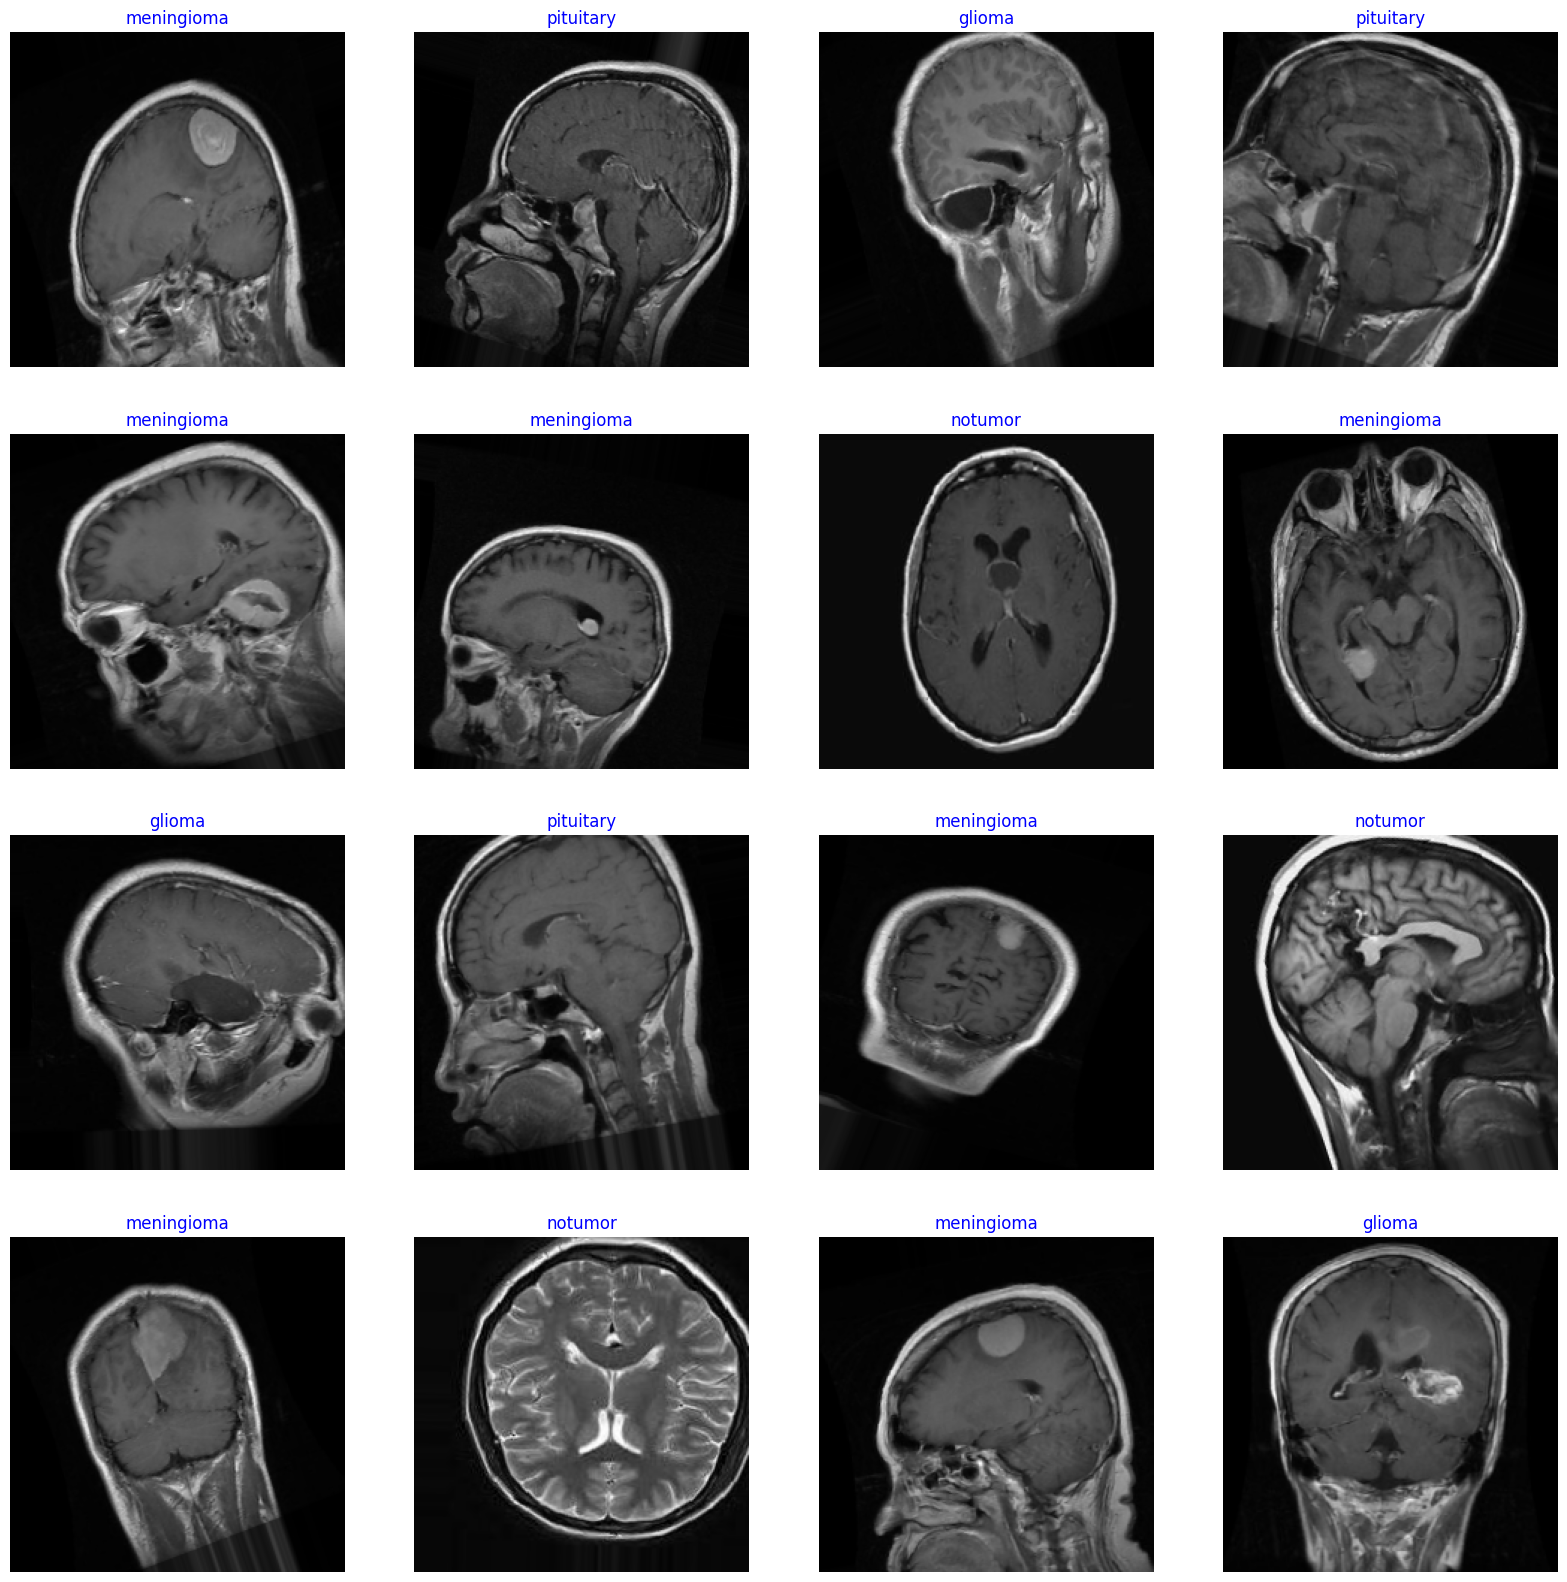

In [ ]:
batch_size = 16  #can be 32 too

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# -------- ImageDataGenerators --------
tr_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  #important for efficientnet
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input    # NO augmentation for valid/test
)

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,           #for fixed evaluation
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

print(f"Train Generator Target Size: {train_gen.target_size}")
print("Class indices:", train_gen.class_indices)

# -------- calculate class weights --------#

class_names = list(train_gen.class_indices.keys())
y_train_labels = train_df['labels'].values

cw_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_names),
    y=y_train_labels
)

class_weights = {
    train_gen.class_indices[class_name]: weight
    for class_name, weight in zip(class_names, cw_values)
}

print("Class weights:", class_weights)

# -------- Show sample images --------#

g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels_batch = next(train_gen)

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i]
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-7)
    plt.imshow(img_norm.astype("float32"))
    index = np.argmax(labels_batch[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


In [ ]:
import tensorflow as tf

# Create Model Structure

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(train_gen.class_indices)

# Pretrained EfficientNetB3

base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

# Freeze base model (first step)
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(
        256,
        kernel_regularizer=regularizers.l2(0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006),
        activation='relu'
    ),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 397,572 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

**train model**

In [ ]:
epochs = 20   #more epochs for more accuracy

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    class_weight=class_weights,
    shuffle=False
)


Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 144s 283ms/step - accuracy: 0.6346 - loss: 13.5357 - val_accuracy: 0.7725 - val_loss: 5.3733
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.6950 - loss: 4.8587 - val_accuracy: 0.7924 - val_loss: 3.2785
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 74s 207ms/step - accuracy: 0.7004 - loss: 3.0071 - val_accuracy: 0.8336 - val_loss: 1.9799
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 75s 210ms/step - accuracy: 0.7170 - loss: 1.9222 - val_accuracy: 0.8382 - val_loss: 1.3301
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 76s 214ms/step - accuracy: 0.7313 - loss: 1.3928 - val_accuracy: 0.8382 - val_loss: 1.0546
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 75s 209ms/step - accuracy: 0.7432 - loss: 1.1823 - val_accuracy: 0.8504 - val_loss: 0.9228
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 76s 212ms/step - accuracy: 0.7579 - loss: 1.0699 - val_accuracy: 0.8580 - val_loss: 0.8571
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 75s 209ms/step - accuracy: 0.7586 - loss:

**fine tunning**

In [ ]:

#  for EfficientNet
base_model.trainable = True
for layer in base_model.layers[:-60]:   # open last 60 layers only
    layer.trainable = False

# إعادة compile ب learning rate صغير
model.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# fine-tuning training
history_ft = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    class_weight=class_weights
)

print("Fine-tuning Done!")


Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 139s 261ms/step - accuracy: 0.7403 - loss: 0.9304 - val_accuracy: 0.8580 - val_loss: 0.6794
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 78s 218ms/step - accuracy: 0.7705 - loss: 0.8486 - val_accuracy: 0.8748 - val_loss: 0.6546
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 79s 220ms/step - accuracy: 0.7894 - loss: 0.8360 - val_accuracy: 0.8962 - val_loss: 0.6254
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 78s 220ms/step - accuracy: 0.7992 - loss: 0.8014 - val_accuracy: 0.8962 - val_loss: 0.6008
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 78s 218ms/step - accuracy: 0.8100 - loss: 0.7872 - val_accuracy: 0.9069 - val_loss: 0.5915
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - accuracy: 0.8312 - loss: 0.7510 - val_accuracy: 0.9145 - val_loss: 0.5760
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 76s 214ms/step - accuracy: 0.8241 - loss: 0.7578 - val_accuracy: 0.9267 - val_loss: 0.5579
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 77s 216ms/step - accuracy: 0.8373 - loss: 

**DisPlay model performance**

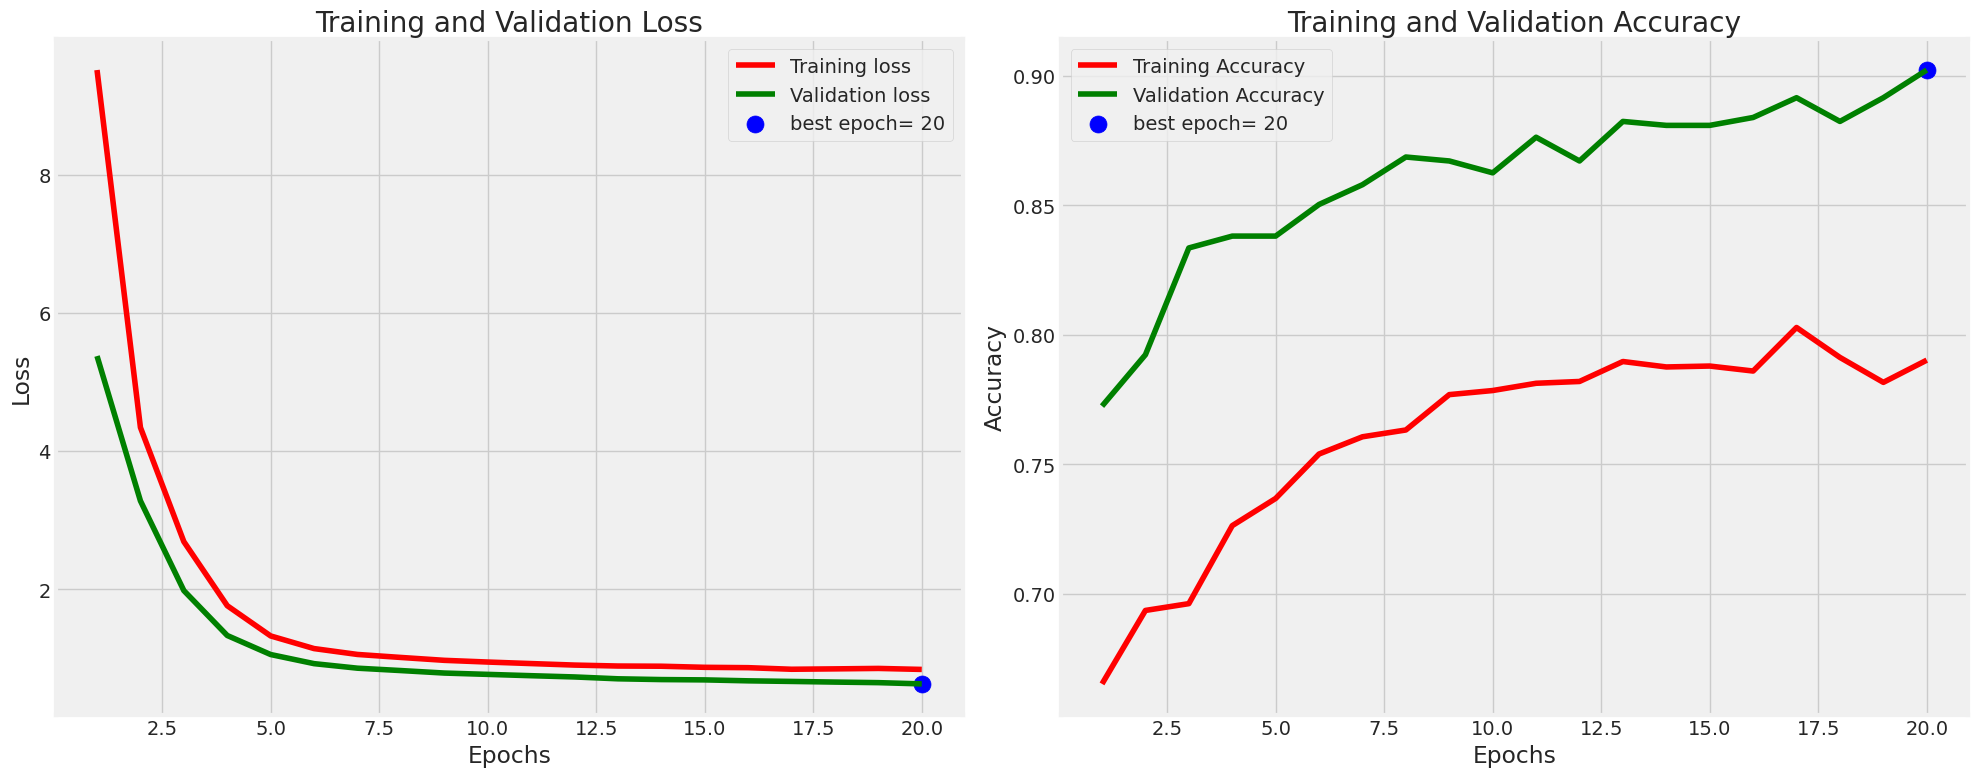

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


****

**Evaluat model**

In [ ]:
train_steps = len(train_gen)
valid_steps = len(valid_gen)
test_steps  = len(test_gen)

train_score = model.evaluate(train_gen, steps=train_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=valid_steps, verbose=1)
test_score  = model.evaluate(test_gen,  steps=test_steps,  verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 74s 207ms/step - accuracy: 0.9693 - loss: 0.4677
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9510 - loss: 0.5085
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9433 - loss: 0.5258
Train Loss:  0.46776047348976135
Train Accuracy:  0.9695377945899963
--------------------
Validation Loss:  0.518882155418396
Validation Accuracy:  0.9465649127960205
--------------------
Test Loss:  0.5182632803916931
Test Accuracy:  0.9466463327407837


**confusion_matrix**

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step


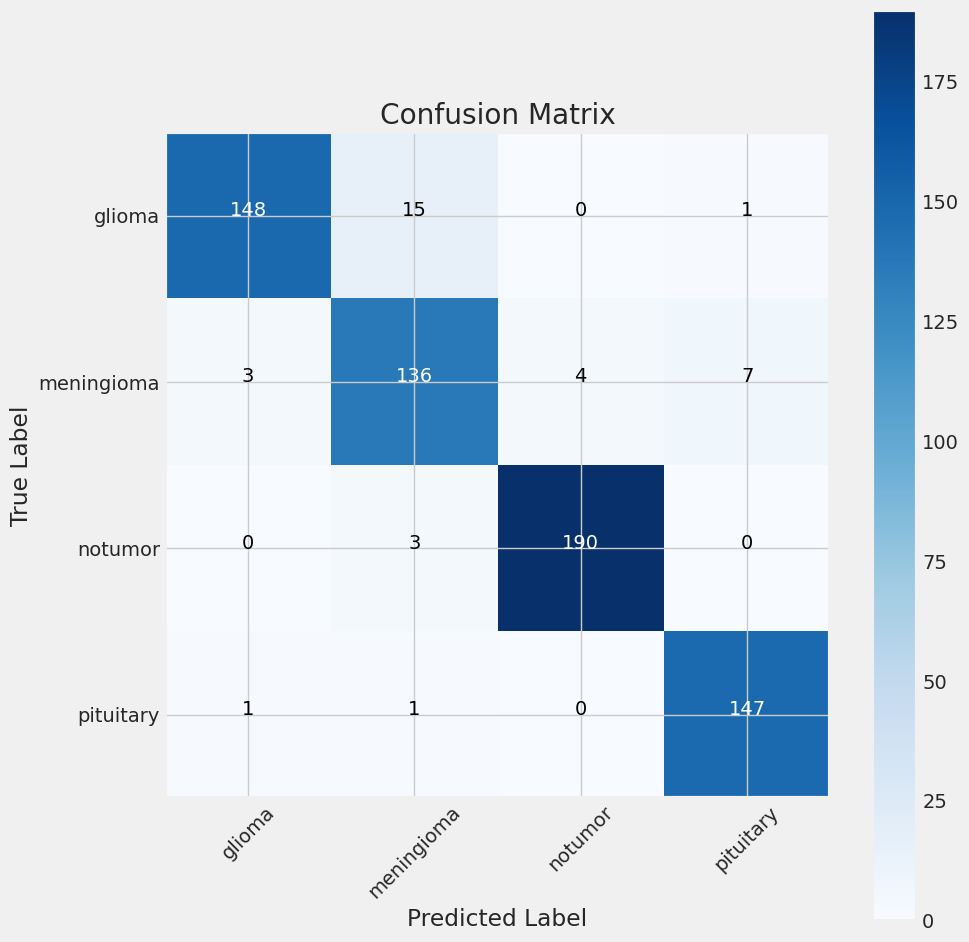

In [ ]:
#-------------get predictions----------------#

preds = model.predict(test_gen, steps=test_steps)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# ------------Confusion matrix------------#
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j, i, cm[i, j],
        horizontalalignment='center',
        color='white' if cm[i, j] > thresh else 'black'
    )

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




# CLASSIFICATION REPORT

In [ ]:

print(classification_report(test_gen.classes, y_pred, target_names=classes))


              precision    recall  f1-score   support

      glioma       0.97      0.90      0.94       164
  meningioma       0.88      0.91      0.89       150
     notumor       0.98      0.98      0.98       193
   pituitary       0.95      0.99      0.97       149

    accuracy                           0.95       656
   macro avg       0.94      0.95      0.94       656
weighted avg       0.95      0.95      0.95       656



#save model

In [ ]:
# Save the fine-tuned model
model.save('/content/brain_tumor_model.h5')
print("Model Saved Successfully!")


Model Saved Successfully!


#Prediction using loaded_model







In [ ]:
loaded_model = tf.keras.models.load_model('/content/brain_tumor_model.h5')

loaded_model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Loaded Successfully!")


Model Loaded Successfully!


****

#check model

Class Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class Order: ['glioma', 'meningioma', 'notumor', 'pituitary']


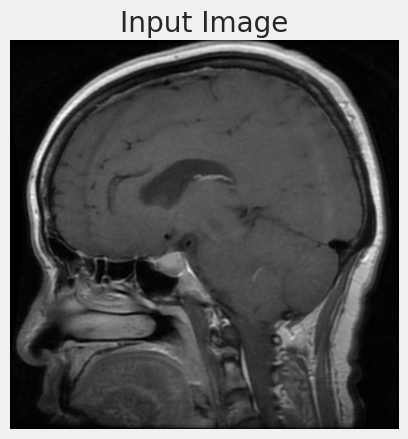

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Prediction: pituitary

Probabilities:
glioma: 18.14%
meningioma: 18.66%
notumor: 18.06%
pituitary: 45.15%


In [ ]:
# 1) Get the correct class labels (VERY IMPORTANT)
class_labels = list(train_gen.class_indices.keys())
print("Class Mapping:", train_gen.class_indices)
print("Class Order:", class_labels)

# 2) Load image path
image_path = '/content/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0003.jpg'

# 3) Load + display the image
img = Image.open(image_path)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')
plt.show()

# 4) Preprocess (resize → array → preprocess_input → expand dims)
img = img.resize((224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

# VERY IMPORTANT: EfficientNet native preprocessing
img = preprocess_input(img)

# Add batch dimension
img = tf.expand_dims(img, 0)

# 5) Predict
pred = loaded_model.predict(img)
score = tf.nn.softmax(pred[0])

# 6) Print results
print("\nPrediction:", class_labels[tf.argmax(score)])
print("\nProbabilities:")
for i, c in enumerate(class_labels):
    print(f"{c}: {score[i].numpy()*100:.2f}%")


**Data Statistics**

In [ ]:
print(test_df['labels'].value_counts())


labels
notumor       193
glioma        164
meningioma    150
pituitary     149
Name: count, dtype: int64


In [ ]:
print(train_df['labels'].value_counts())

labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


In [ ]:
print(valid_df['labels'].value_counts())


labels
notumor       212
meningioma    156
pituitary     151
glioma        136
Name: count, dtype: int64
